# COGS 108 - EDA Checkpoint

# Names

- Hugs Clorina
- John Howell
- Andy Chow
- Jawad Osman
- Vince Ermitano

<a id='research_question'></a>
# Research Question

Is there a statistically significant correlation between rising ocean temperature and sea level with the frequency of unprovoked shark attacks in North America?

# Setup

In [1]:
# Import seaborn and apply its plotting styles
import seaborn as sns
sns.set(font_scale=2, style="white")

# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
# set plotting size parameter
plt.rcParams['figure.figsize'] = (17, 7)

# import pandas & numpy library
import pandas as pd
import numpy as np

# import datetime for date parsing
from datetime import datetime, timedelta

# import patsy and statsmodels for linear regression
import patsy
import statsmodels.api as sm

from scipy import stats

In [2]:
# read in all datasets
sharks_df = pd.read_csv("./shark_attacks.csv")
temp_df = pd.read_csv("./temperature_anomalies.csv")
sl_pacific_df = pd.read_csv("./sea_level_north_pacific.csv")
sl_atlantic_df = pd.read_csv("./sea_level_north_atlantic.csv")

# Data Cleaning

## Shark attack

The data that needs the most cleaning work done is the shark attack data because
- it contains columns that are irrelevant to our research or revealed personal information
- it contains shark attacks in regions/areas of the world that are not relevant to our scope.
- it contains rows for *provoked* shark attacks when we are really trying to research relative to *unprovoked* shark attacks
- it is missing categorization of areas of attacks between East and West Coast

Thus, pertaining to the shark attack data, we cleaned up our data as follows:
1. read in the shark attack csv file
2. filtered the dataset to only areas that we of interest (North America)
    * looked at all unique values for countries
    * defined which of these values to retain
    * dropped rows for values in which don't exist in our area of interest
3. filtered the dataset to only include rows that had their 'Type' column value as 'unprovoked'
4. dropped columns that were either irrelevant or included personal data
5. categorized the areas into East and West Coast appropriately

In [3]:
# get a feel for the data
print(sharks_df.shape)
print(sharks_df.columns)

(25847, 24)
Index(['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex ', 'Age', 'Injury', 'Fatal (Y/N)', 'Time',
       'Species ', 'Investigator or Source', 'pdf', 'href formula', 'href',
       'Case Number.1', 'Case Number.2', 'original order', 'Unnamed: 22',
       'Unnamed: 23'],
      dtype='object')


In [4]:
# look at all unique countries
print(sharks_df['Country'].unique())

# filter by area, unprovoked attacks, and relevant year frame
sharks_df = sharks_df[sharks_df['Country'] == 'USA']
sharks_df = sharks_df[sharks_df['Type'] == 'Unprovoked']
sharks_df = sharks_df[sharks_df['Year'] >= 1880]

# drop irrelevant or ethically exposing columns
sharks_df = sharks_df.drop(columns=['Investigator or Source', 'Injury', 'Time', 'pdf','Species ', 'href formula', 'Name', 'Unnamed: 22', 'Unnamed: 23', 'Case Number.1', 'Case Number.2', 'href', 'original order']).reset_index(drop=True)

['USA' 'BAHAMAS' 'AUSTRALIA' 'SOUTH AFRICA' 'ENGLAND' 'JAPAN' 'INDONESIA'
 'EGYPT' 'JA MAICA' 'BELIZE' 'MALDIVES' 'FRENCH POLYNESIA' 'THAILAND'
 'COLUMBIA' 'NEW ZEALAND' 'MEXICO' 'COSTA RICA' 'New Zealand' 'BRAZIL'
 'British Overseas Territory' 'CANADA' 'ECUADOR' 'JORDAN' 'NEW CALEDONIA'
 'JAMAICA' 'ST KITTS / NEVIS' 'ST MARTIN' 'SPAIN' 'FIJI' 'SEYCHELLES'
 'PAPUA NEW GUINEA' 'REUNION ISLAND' 'ISRAEL' 'CHINA' 'SAMOA' 'IRELAND'
 'ITALY' 'COLOMBIA' 'MALAYSIA' 'LIBYA' nan 'CUBA' 'MAURITIUS'
 'SOLOMON ISLANDS' 'ST HELENA, British overseas territory' 'COMOROS'
 'REUNION' 'UNITED KINGDOM' 'UNITED ARAB EMIRATES' 'PHILIPPINES'
 'CAPE VERDE' 'Fiji' 'DOMINICAN REPUBLIC' 'CAYMAN ISLANDS' 'ARUBA'
 'MOZAMBIQUE' 'PUERTO RICO' 'ATLANTIC OCEAN' 'GREECE' 'ST. MARTIN'
 'FRANCE' 'TRINIDAD & TOBAGO' 'KIRIBATI' 'DIEGO GARCIA' 'TAIWAN'
 'PALESTINIAN TERRITORIES' 'GUAM' 'NIGERIA' 'TONGA' 'SCOTLAND' 'CROATIA'
 'SAUDI ARABIA' 'CHILE' 'ANTIGUA' 'KENYA' 'RUSSIA' 'TURKS & CAICOS'
 'UNITED ARAB EMIRATES (UAE)' 'AZ

In [5]:
# categorize 'Area' column values to 'East Coast' or 'West Coast'
print(sharks_df['Area'].unique())

west_coast = ['California', 'Hawaii', 'Texas', 'Oregon', 'Guam', 'Maui', 'Baja ', 'Guerrero',
              'Washington', 'Baja California Sur', 'Palmyra Atoll', 'Johnston Atoll', 'Midway Atoll']

east_coast = ['Louisiana', 'South Carolina', 'Florida','New York', 'Noirth Carolina', 'Alabama',
              'Maryland', 'North Carolina', 'Georgia', 'Franklin County, Florida', 'Virgin Islands',
              'Maine', 'Bahamas', 'Cayman Islands', 'Rhode Island', 'New Jersey', 'Massachusetts', 'Delaware',
              'Virginia', 'Puerto Rico', 'US Virgin Islands', 'South Carolina ', 'Connecticut', 'Mississippi',
              'Wake Island', ' North Carolina', 'East coast']

['California' 'Hawaii' 'Louisiana' 'South Carolina' 'Florida' 'New York'
 'Noirth Carolina' 'Alabama' 'Texas' 'Maryland' 'North Carolina' 'Georgia'
 'Oregon' 'Franklin County, Florida' 'Virgin Islands' 'Maine' 'Bahamas'
 'Maui' 'Guam' 'Cayman Islands' 'Rhode Island' 'New Jersey'
 'Massachusetts' 'Washington' 'Delaware' 'Palmyra Atoll' 'Puerto Rico'
 'Virginia' 'US Virgin Islands' 'South Carolina ' 'Johnston Atoll'
 'Connecticut' 'Mississippi' 'Wake Island' ' North Carolina'
 'Midway Atoll' 'East coast']


In [6]:
def categorize_east_west(str_in):
    if str_in in west_coast:
        return 'West Coast'
    return 'East Coast'

sharks_df['West/East Coast'] = sharks_df['Area'].apply(categorize_east_west)

In [7]:
# take a look at our cleaned-up shark data
sharks_df.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Sex,Age,Fatal (Y/N),West/East Coast
0,2022.10.31,31-Oct-2022,2022.0,Unprovoked,USA,California,"Otter Point, Pacific Grove",Surfing,M,NaN,N,West Coast
1,2022.10.25,25 Oct-2022,2022.0,Unprovoked,USA,Hawaii,Kauai,Snorkeling,M,51,N,West Coast
2,2022.10.08,08-Oct-2022,2022.0,Unprovoked,USA,Louisiana,25 miles off Empire,Shipwreck,M,40,N,East Coast
3,2022.010.02,02-Oct-2022,2022.0,Unprovoked,USA,California,Centerville Beach,Surfing,M,31,N,West Coast
4,2022.09.03,03-Sep-2022,2022.0,Unprovoked,USA,Hawaii,"Lower Paia Beach Park, Maui",Swimming or Snorkeling,F,51,N,West Coast


In [8]:
sharks_df.dtypes

Case Number         object
Date                object
Year               float64
Type                object
Country             object
Area                object
Location            object
Activity            object
Sex                 object
Age                 object
Fatal (Y/N)         object
West/East Coast     object
dtype: object

Here, we parse the dates.
Note:
1. There are cases with reported date. They are in the format `'Reported 01-Jan-2022'`. We acknowledge that the date provided here might not be accurate.
2. If date is None, it means that the case has no exact date. e.g. only provided year, season, month, etc. The full list of rejected entries are printed below.

In [9]:
def string_to_date(str_in):
    try:
        # clean up entries
        str_in  = str_in.replace('Reported','')
        str_in = str_in.strip(' .abcde')
        str_in  = str_in.replace(' ','-')
        str_in  = str_in.replace('--','-')

        # Handle edge cases
        if str_in in ['20-May2015', '13-May2014', '29-Nov2013']:
            return datetime.strptime(str_in, '%d-%b%Y')
        if str_in == '12-July-1913':
            str_in = '12-Jul-1913'
        if str_in == '10-Jul-202':  # Checked case number, year is 2020
            str_in = '10-Jul-2020'

        return datetime.strptime(str_in, '%d-%b-%Y')
    except ValueError:
        print(str_in)
        return None

# TODO: not applied to the main df
sharks_df['Date'].apply(string_to_date)

May-2016
2014
Apr-2013
Jun-2010
Sep-2008
Aug-2006
July-2006
July-2006
Sep-2003
Jul-2003
Jul-2001
Mar-2000
1998
1996
1995
1994
Dec-1993
Oct-1993
Jun-1993
1993
Sep-1992
July-1991
1990
Apr-1989
1989
Oct-1988
Oct-1986
Sep-1986
Sep-1986
1986
1984
Nov-1982
Late-Jul-1980
Early-Jul-1980
1979
1978
1976
Sep-1974
1971
Oct-1970
Sep-1970
Sep-1970
Jun-1969
Aug-1966
Summer-1965
Feb-1964
Oct-1961
Aug-1960
Jul-1958
May-1957
Feb-1957
1957
1957
1956
Apr-1955
1955
1954
1953
1952
Jul-1950
1950
Fall-1943
Fall-1943
1943
1929
Sep-1928
Nov-1925
Nov-1925
May-1925
Feb-1923
1919
Nov-1918
1911
Jul-1907
1907
Late-Aug-1905
Jul-1905
1904
Ca.-1903
Summer-1901
Early-1900s
Ca.-1899
1898
1898-1899
1896
Summer-of-1883
1883
1882


0      2022-10-31
1      2022-10-25
2      2022-10-08
3      2022-10-02
4      2022-09-03
          ...    
1855          NaT
1856          NaT
1857   1881-09-05
1858   1881-08-12
1859   1881-06-13
Name: Date, Length: 1860, dtype: datetime64[ns]

Here, we parse the ages.
Note:
1. Some ages uses age range, e.g. mid-30s, 60s, here, we use x+5 for 'mid-x's' and x for 'x's'
2. When dealing with ambiguous ages (12 or 13, 21 or 26), we take the average of the 2 ages.
3. We decided not to include ages of cases with multiple victims. However, we will be keeping the cases.
4. If age is None, it means that:
    1. no age is given, in the case of Nan;
    2. no exact age is given. e.g. teen, minor, elderly, etc;
    3. the case has multiple victims; or
    4. the age is invalid or too ambiguous to parse. e.g. `!6, !!`

The full list of rejected entries are printed below.

In [10]:
def age_to_float(age_in):
    if type(age_in) is float:  # Nan here is float
        return age_in

    try:
        age_in = age_in.strip(' \'s')
        if 'mid' in age_in:
            age_in.replace('mid-', '')
            return float(age_in) + 0.5

        if ' or ' in age_in:
            age1, age2 = age_in.split(' or ')
            return (float(age1) + float(age2)) / 2

        # Handle edge cases
        if age_in == '6½':
            return 6.5

        return float(age_in)
    except ValueError:
        print(age_in)
        return None

# TODO: Cases with multiple victims not accounted for
sharks_df['Age'] = sharks_df['Age'].apply(age_to_float)

teen
Teen
!6
!!
Teen
22, 57, 31
a minor
Teen
Teen
Teen
teen
teen
teen
Teen
teen
mid-30
Elderly
9 & 12


In [11]:
sharks_df['Year'] = sharks_df['Year'].astype(int)
sharks_df['Fatal (Y/N)'] = sharks_df['Fatal (Y/N)'].str.replace('Nq', 'N')

# Now all case in the data are unprovoked, 'Type' column is not necessary
sharks_df = sharks_df.drop(columns=['Type'])

sharks_df

,Case Number,Date,Year,Country,Area,Location,Activity,Sex,Age,Fatal (Y/N),West/East Coast
0,2022.10.31,31-Oct-2022,2022,USA,California,"Otter Point, Pacific Grove",Surfing,M,NaN,N,West Coast
1,2022.10.25,25 Oct-2022,2022,USA,Hawaii,Kauai,Snorkeling,M,51.0,N,West Coast
2,2022.10.08,08-Oct-2022,2022,USA,Louisiana,25 miles off Empire,Shipwreck,M,40.0,N,East Coast
3,2022.010.02,02-Oct-2022,2022,USA,California,Centerville Beach,Surfing,M,31.0,N,West Coast
4,2022.09.03,03-Sep-2022,2022,USA,Hawaii,"Lower Paia Beach Park, Maui",Swimming or Snorkeling,F,51.0,N,West Coast
...,...,...,...,...,...,...,...,...,...,...,...
1855,1883.00.00.a,1883,1883,USA,South Carolina,NaN,NaN,M,NaN,Y,East Coast
1856,1882.00.00.b,1882,1882,USA,Florida,"In the bay near the naval yard at Pensacola, E...","During ""an exhibition"" he was tied in sack & t...",M,NaN,N,East Coast
1857,1881.09.05,05-Sep-1881,1881,USA,North Carolina,"Elizabeth City, Pasquotank County",Bathing,M,NaN,Y,East Coast
1858,1881.08.12,12-Aug-1881,1881,USA,Rhode Island,Providence,Swimming,M,NaN,N,East Coast


## Ocean temperature anomalies

For the remaining datasets (sea_level & temperature_anomalies), most of the data we already clean so we only made the following changes:
1. Removed first 4 rows in the ocean temperature dataset because it stored irrelevant data.
2. The intial column names in the ocean temperature dataset did not make sense for the values that are stored, so we changed the column names to appropriate titles (Year, Temperature Anomaly (Celsius))
3. Change data types from string to int(for year) or float(for temperature anomaly)

In [12]:
# get a feel for the data
print(temp_df.shape)
print(temp_df.columns)

temp_df.head()

(146, 2)
Index(['Northern Hemisphere Ocean Temperature Anomalies', ' January-December'], dtype='object')


,Northern Hemisphere Ocean Temperature Anomalies,January-December
0,Units: Degrees Celsius,NaN
1,Base Period: 1901-2000,NaN
2,Missing: -999,NaN
3,Year,Value
4,1880,-0.02


In [13]:
# need to remove unnecessary initial rows (0-4)
temp_df = temp_df.loc[4:].reset_index(drop=True)

# rename column titles appropriately
temp_df = temp_df.rename(columns={'Northern Hemisphere Ocean Temperature Anomalies': 'year', ' January-December': 'temperature_anomaly_cel'})

temp_df.head()

,year,temperature_anomaly_cel
0,1880,-0.02
1,1881,-0.02
2,1882,-0.03
3,1883,-0.08
4,1884,-0.16


In [14]:
temp_df.dtypes

year                       object
temperature_anomaly_cel    object
dtype: object

In [15]:
temp_df['year'] = temp_df['year'].astype(int)
temp_df['temperature_anomaly_cel'] = temp_df['temperature_anomaly_cel'].astype(float)
temp_df.dtypes

year                         int32
temperature_anomaly_cel    float64
dtype: object

## Sea Level

The sea level data we already clean, so we just read the dataset in with no modifications

In [16]:
# northern pacific sea level data
print(sl_pacific_df.shape)
sl_pacific_df.head()

(1375, 5)


,year,TOPEX/Poseidon,Jason-1,Jason-2,Jason-3
0,1992.9611,13.06,NaN,NaN,NaN
1,1992.9865,-4.77,NaN,NaN,NaN
2,1993.0126,-3.39,NaN,NaN,NaN
3,1993.0408,-20.67,NaN,NaN,NaN
4,1993.0659,-31.04,NaN,NaN,NaN


In [17]:
# northern atlantic sea level data
print(sl_atlantic_df.shape)
sl_atlantic_df.head()

(1378, 5)


,year,TOPEX/Poseidon,Jason-1,Jason-2,Jason-3
0,1992.9620,-17.99,NaN,NaN,NaN
1,1992.9873,-9.87,NaN,NaN,NaN
2,1993.0129,-17.22,NaN,NaN,NaN
3,1993.0413,-0.27,NaN,NaN,NaN
4,1993.0667,-19.85,NaN,NaN,NaN


In [18]:
# While decimal year is useful for linear regression, we want to add a column of dates for easier reading
def decimal_year_to_date(year_in):
    year_out = int(year_in)
    year_begin = datetime(year_out, 1, 1)
    year_end = datetime(year_out + 1, 1, 1)
    fraction = year_in - year_out
    result = year_begin + timedelta(seconds=(year_end - year_begin).total_seconds() * fraction)
    return result.date()

In [19]:
pacific_col = sl_pacific_df['year'].apply(decimal_year_to_date)
sl_pacific_df_view = sl_pacific_df.copy()
sl_pacific_df_view.insert (0, "date", pacific_col)

atlantic_col = sl_atlantic_df['year'].apply(decimal_year_to_date)
sl_atlantic_df_view = sl_atlantic_df.copy()
sl_atlantic_df_view.insert (0, "date", atlantic_col)

sl_pacific_df_view.head()

,date,year,TOPEX/Poseidon,Jason-1,Jason-2,Jason-3
0,1992-12-17,1992.9611,13.06,NaN,NaN,NaN
1,1992-12-27,1992.9865,-4.77,NaN,NaN,NaN
2,1993-01-05,1993.0126,-3.39,NaN,NaN,NaN
3,1993-01-15,1993.0408,-20.67,NaN,NaN,NaN
4,1993-01-25,1993.0659,-31.04,NaN,NaN,NaN


In [20]:
sl_atlantic_df_view.head()

,date,year,TOPEX/Poseidon,Jason-1,Jason-2,Jason-3
0,1992-12-18,1992.9620,-17.99,NaN,NaN,NaN
1,1992-12-27,1992.9873,-9.87,NaN,NaN,NaN
2,1993-01-05,1993.0129,-17.22,NaN,NaN,NaN
3,1993-01-16,1993.0413,-0.27,NaN,NaN,NaN
4,1993-01-25,1993.0667,-19.85,NaN,NaN,NaN


# Data Analysis & Results (EDA)

First, we will be checking the data for both the sea level and ocean temperature. Here we plotted the data of sea level and ocean temperature against time.

<AxesSubplot: xlabel='year', ylabel='sl-change'>

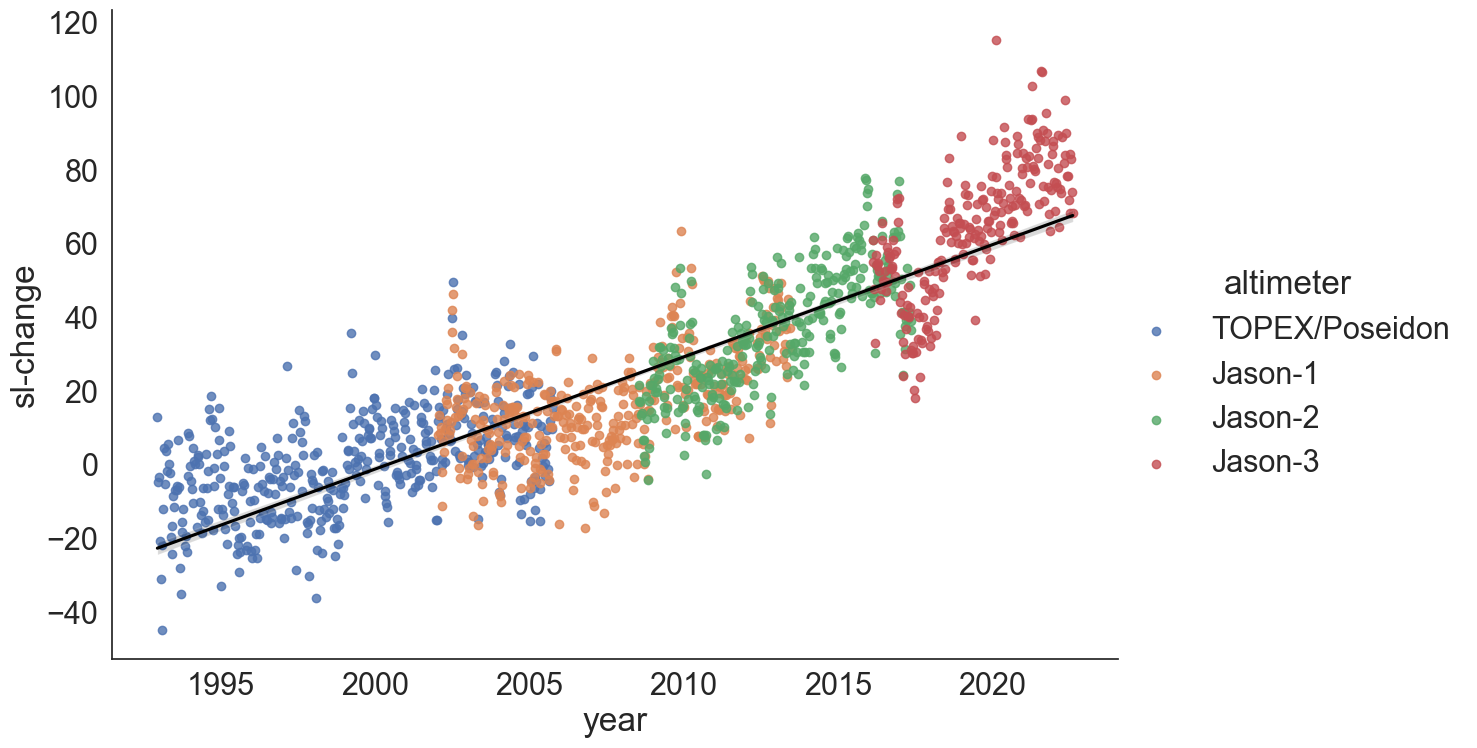

In [21]:
dfm = sl_pacific_df.melt('year', var_name='altimeter', value_name='sl-change')
fig_a1 = sns.lmplot(data=dfm, x='year', y='sl-change', hue='altimeter', hue_order=['TOPEX/Poseidon','Jason-1','Jason-2','Jason-3'], height=8, aspect=1.5, fit_reg=False)
sns.regplot(data=dfm, x='year', y='sl-change', scatter=False, ax=fig_a1.axes[0, 0], color='black')

<AxesSubplot: xlabel='year', ylabel='sl-change'>

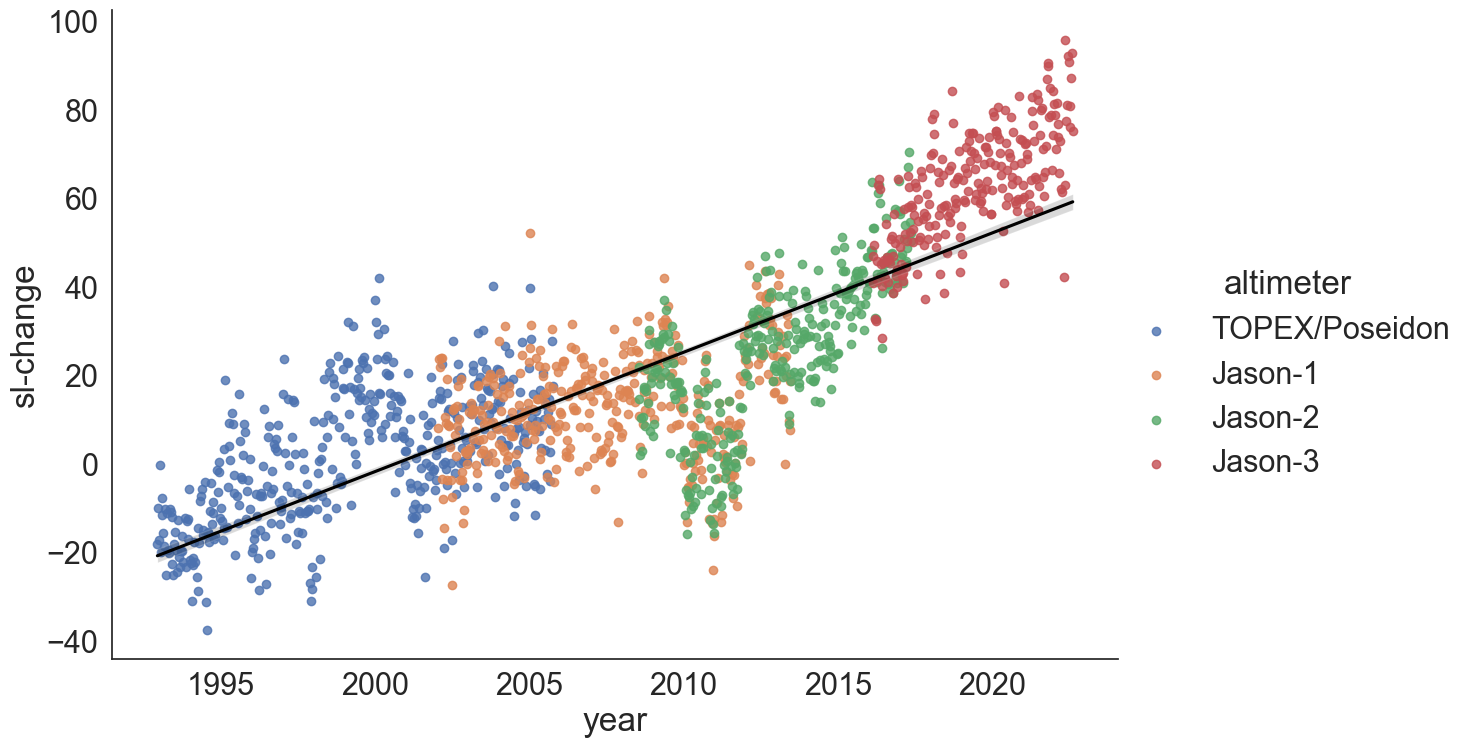

In [22]:
dfm = sl_atlantic_df.melt('year', var_name='altimeter', value_name='sl-change')
fig_a2 = sns.lmplot(data=dfm, x='year', y='sl-change', hue='altimeter', hue_order=['TOPEX/Poseidon','Jason-1','Jason-2','Jason-3'], height=8, aspect=1.5, fit_reg=False)
sns.regplot(data=dfm, x='year', y='sl-change', scatter=False, ax=fig_a2.axes[0, 0], color='black')

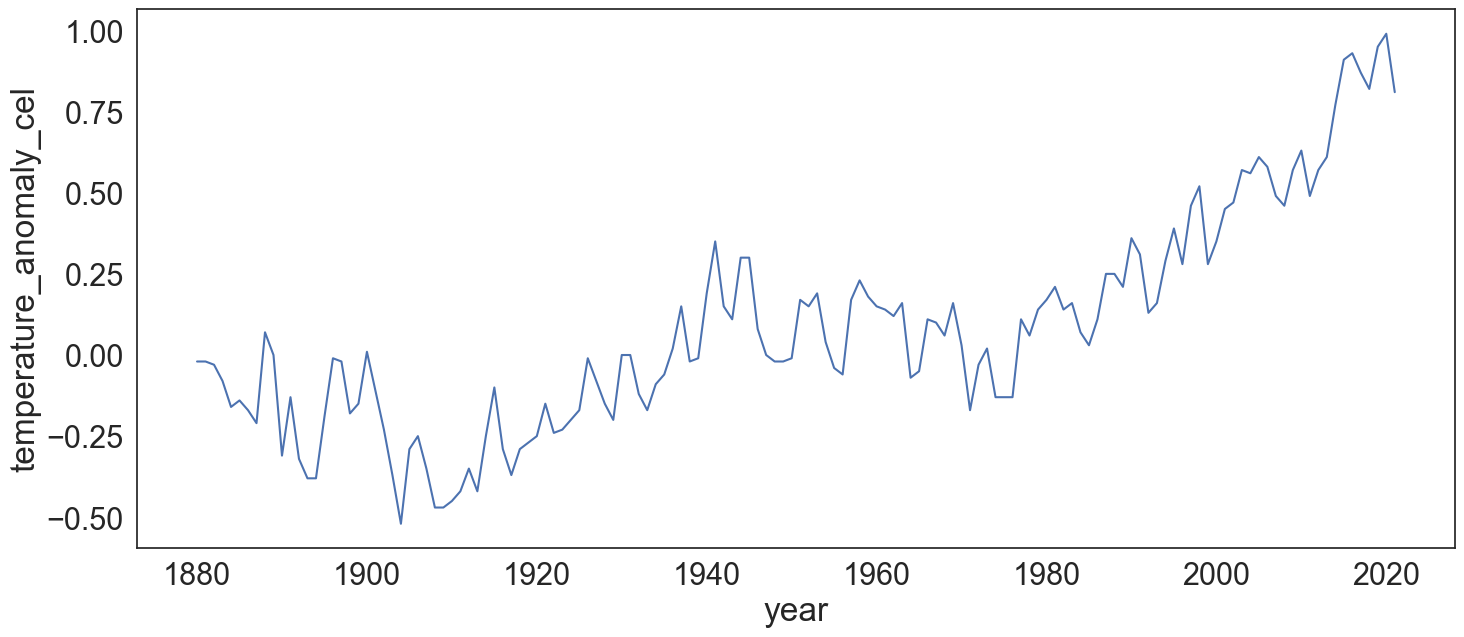

In [23]:
fig_a3 = sns.lineplot(data=temp_df, x='year', y='temperature_anomaly_cel')

We have a rough understanding of the ocean climate over the past years: the sea level and ocean temperature is slowly increasing over the years from 1880 to now.

Next we looked at the age distribution of shark attack victims. Below is the histogram of shark attack victims' age. The left graph are fatal cases, the right graph is non-fatal cases. Notice is count (y-axis) for both graphs are significantly different.

<AxesSubplot: xlabel='Age', ylabel='Count'>

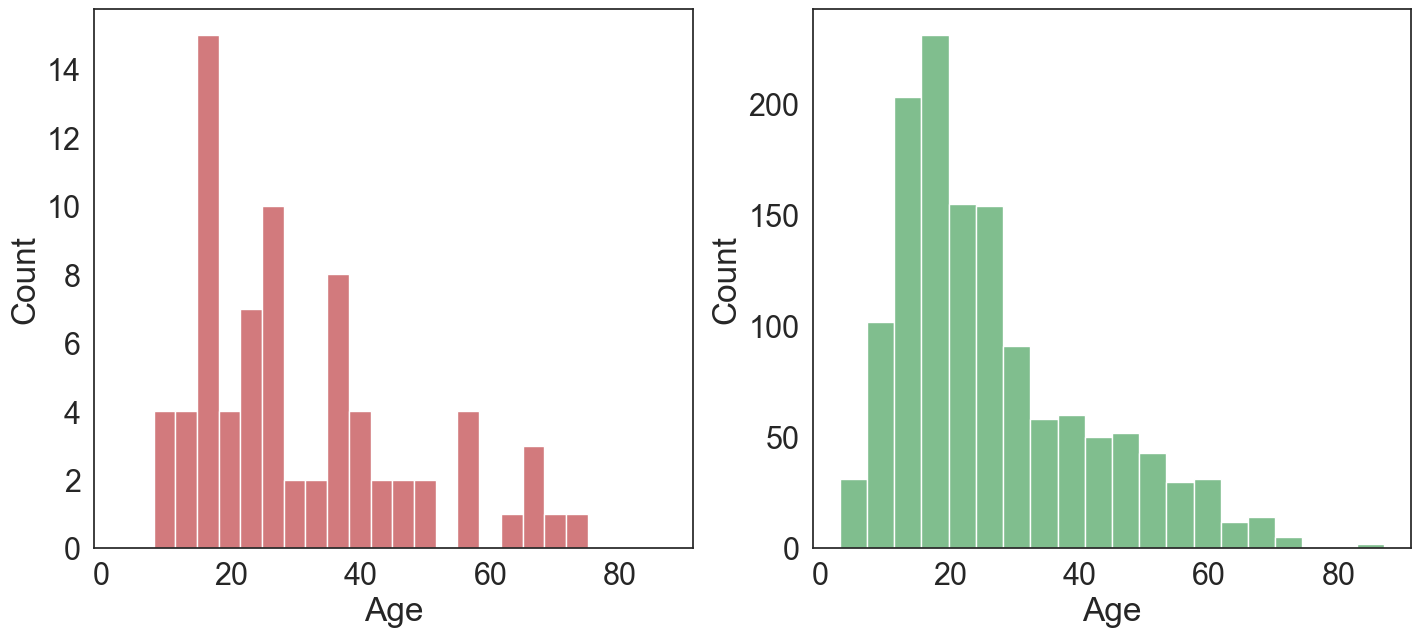

In [24]:
fig_a4, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
sns.histplot(data=sharks_df[sharks_df['Fatal (Y/N)'] == 'Y'], x='Age', bins=20, color='#c44e52', ax=ax1)
sns.histplot(data=sharks_df[sharks_df['Fatal (Y/N)'] == 'N'], x='Age', bins=20, color='#55a868', ax=ax2)

Additionally, this is a box plot of shark attack victims' age, sorted by fatal cases.

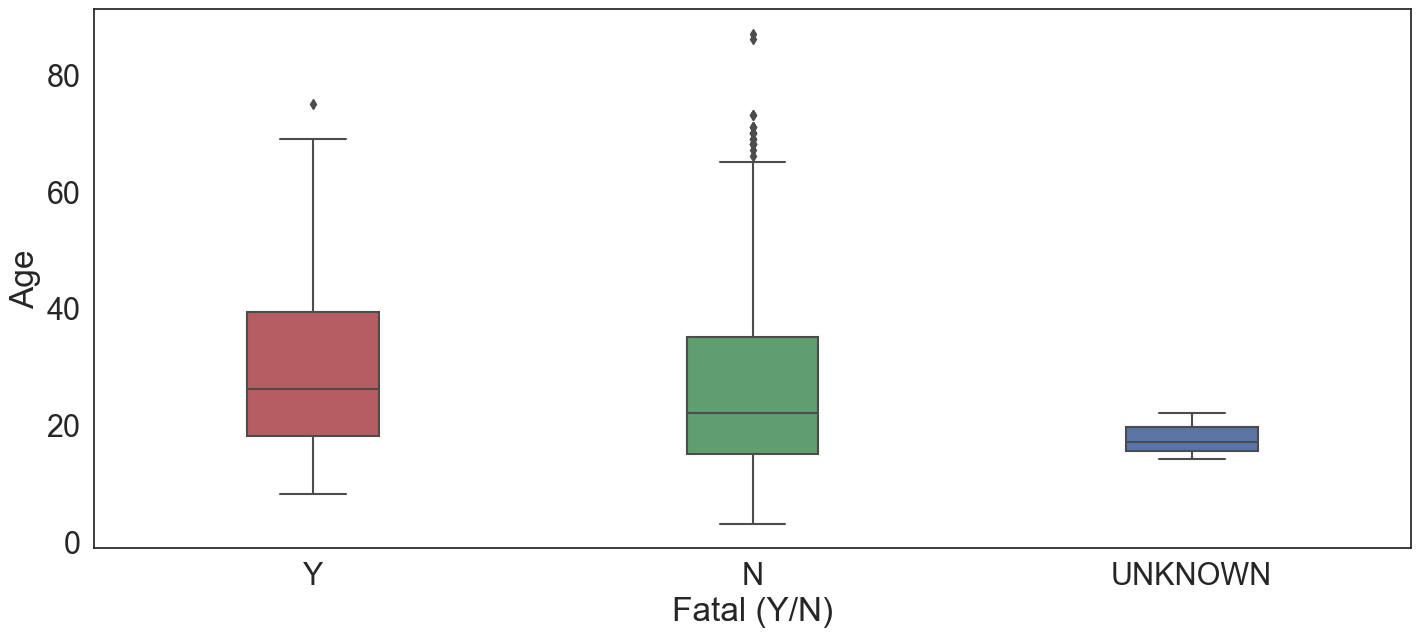

In [25]:
palette_diff_order = sns.color_palette(['#c44e52','#55a868','#4c72b0'])
fig_a5 = sns.boxplot(data=sharks_df, x='Fatal (Y/N)', y="Age", width=0.3, order=['Y', 'N', 'UNKNOWN'], palette=palette_diff_order)

Both histograms show an approximately normal distribution, with some left skew for both plots. This makes sense since younger people would do more ocean activities compared to older people.
Combined with the boxplots, the age distribution looks mostly normal, with the exception of some outliers: two non-fatal cases with victims over the age of 80. we decide to look at the two cases.

In [26]:
sharks_df[sharks_df['Age'] >= 80]

,Case Number,Date,Year,Country,Area,Location,Activity,Sex,Age,Fatal (Y/N),West/East Coast
569,2011.05.13.b,13-May-2011,2011,USA,Florida,"Ponte Vedra Beach, St Johns County",Body surfing,M,86.0,N,East Coast
1358,1985.08.22,22-Aug-1985,1985,USA,South Carolina,"Palmetto Dunes, Hilton Head, Beaufort County",Wading,M,87.0,N,East Coast


Looking at these two cases, nothing is out of the ordinary. We decide to keep these two cases.

## Exploring Correlation Between Sea Level Rise and Shark Attacks

Let's take a look at the number of unprovoked shark attacks recorded each year.

<AxesSubplot: xlabel='Year', ylabel='num_of_shark_attacks'>

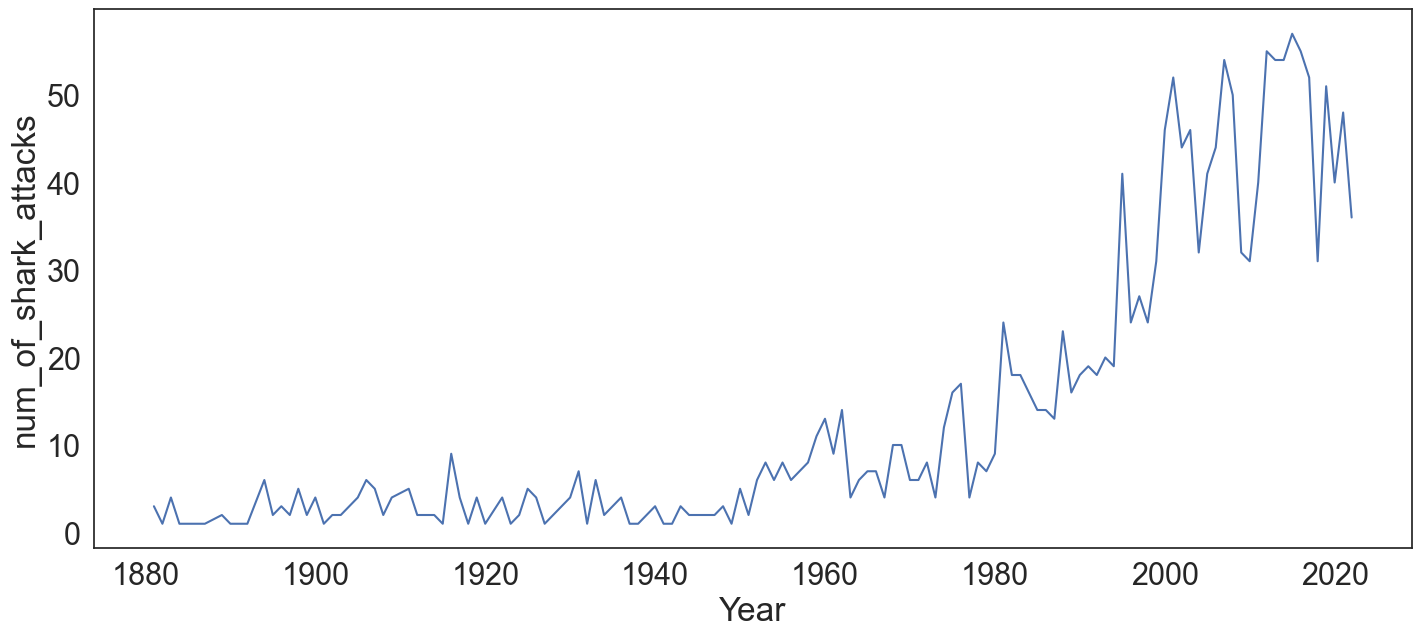

In [27]:
#shark attacks over the years
num_shark_atks_per_year = sharks_df.groupby(['Year'])['Year'].size().reset_index(name='num_of_shark_attacks')
sns.lineplot(data = num_shark_atks_per_year, x='Year', y='num_of_shark_attacks')

We can see that from this plot that shark attack recordings have been increasing over the years and recall that we also earlier plotted sea level rise which also appears to have been increasing. This likely indicates that a relationship exists between the two so let's go ahead and explore this between both the pacific and atlantic oceans.

The goal is to perform linear regression to see the relationship between these two variables (sea-level and number of shark attacks), analyze the summary (coefficient, p-value, and confidence interval) of the model, provide visual representation of potential correlation through regression plots, and see if our results do, in fact, support such a correlation.

## Procedure:
1. Obtain the number of shark attacks per year
2. Obtain median sea level measurments per year
3. Check to see if there is correlation between these two variables using scatter plots and  linear regression

Let's explore the relationship and execute this procedure between the number of shark attacks in the **West Coast** with the **Pacific** Ocean sea level measurements first.

##### Obtain number of shark attacks per year

In [28]:
# create dataframe for # of shark attacks per year
num_shark_atks_per_year = sharks_df[sharks_df['West/East Coast'] == 'West Coast']
num_shark_atks_per_year = num_shark_atks_per_year.groupby(['Year'])['Year'].size().reset_index(name='num_of_shark_attacks')

num_shark_atks_per_year

,Year,num_of_shark_attacks
0,1883,1
1,1889,1
2,1892,1
3,1896,1
4,1898,1
...,...,...
98,2018,8
99,2019,20
100,2020,11
101,2021,13


Let's create a lineplot to visualize the number of shark attacks in the west coast over the years.

[Text(0.5, 1.0, 'Shark Attacks Per Year (West Coast)')]

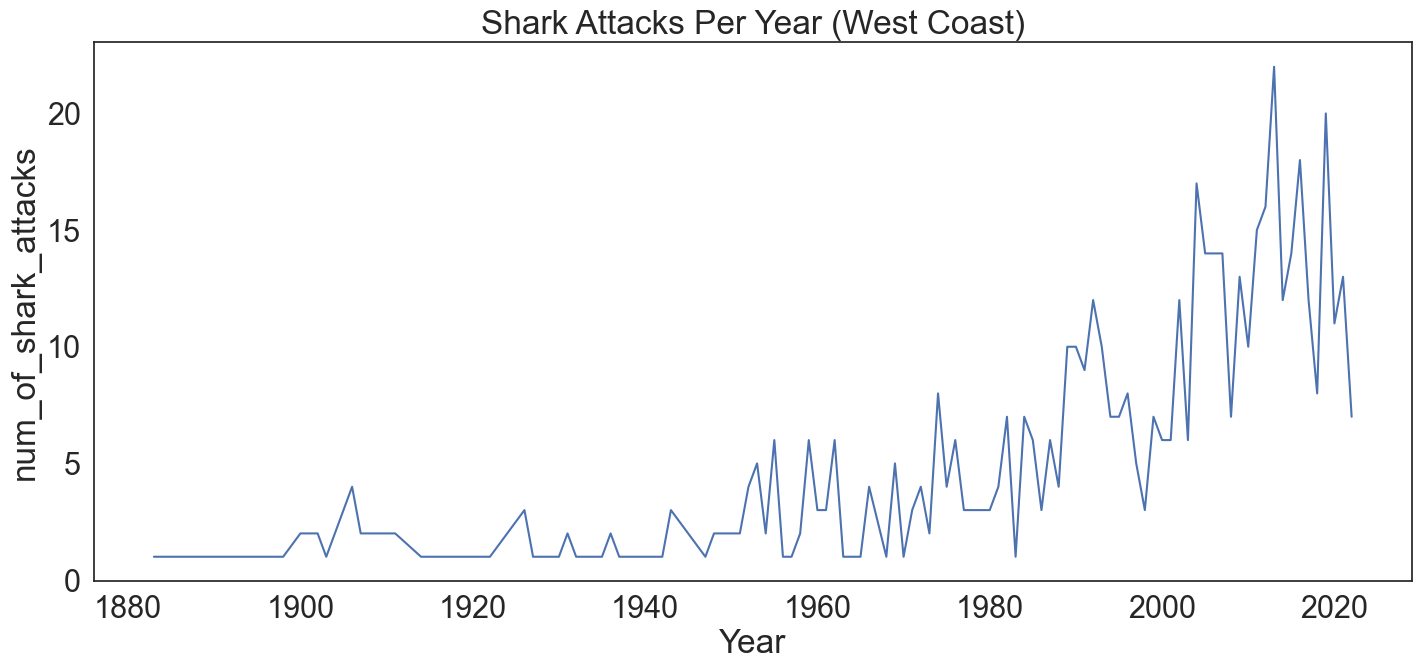

In [29]:
sns.lineplot(data=num_shark_atks_per_year, x='Year', y='num_of_shark_attacks').set(title='Shark Attacks Per Year (West Coast)')

As we can see, there seems to be a generally increasing trend in which the number of unprovoked shark attacks have been increasing over the years. We also notice that shark attacks continue to be very rare despite this upward trend because the maximum number of shark attacks in a given year is about 22 where the minimum number on other years was 1. That's only a 21 difference in count!

Let's gather the sea level change measurements now per year to join it with the shark attacks per year data.

##### Obtain median sea level measurments per year

Since we would like to compare the number of shark attacks and the change in sea level annually, we are going to gather the *median* sea level change measurements per year. This way we can capture the overall picture in the change of sea level each year and ignore the fluctuations due to seasonal changes.

In [30]:
# create dataframe for mean/median of sea level dataframe

# create single column for sea level to avoid NaN values
def create_single_level_measurement(x):
    if not pd.isnull(x['Jason-3']):
        x['Sea Level'] = x['Jason-3']
    elif not pd.isnull(x['Jason-2']):
        x['Sea Level'] = x['Jason-2']
    elif not pd.isnull(x['Jason-1']):
        x['Sea Level'] = x['Jason-1']
    else:
        x['Sea Level'] = x['TOPEX/Poseidon']
    return x

# update pacific sea level dataframe using the standardizing function
sl_pacific_new = sl_pacific_df.apply(create_single_level_measurement, axis=1)
sl_pacific_new['year'] = sl_pacific_new['year'].astype(int)
sl_pacific_new = sl_pacific_new.drop(['TOPEX/Poseidon', 'Jason-1', 'Jason-2', 'Jason-3'], axis=1)

# calculate median for each year in the dataframe
sl_pacific_new = sl_pacific_new.groupby(['year'])['Sea Level'].median().reset_index(name='median_sea_level')

In [31]:
# make sure our dataframe appears correct
sl_pacific_new 

,year,median_sea_level
0,1992,4.145
1,1993,-9.935
2,1994,-1.340
3,1995,-12.335
4,1996,-7.940
5,1997,-4.160
6,1998,-11.830
7,1999,6.590
8,2000,4.175
9,2001,3.015


We can now merge the dataset of yearly median sea level and number of shark attacks to be used to perform linear regression.

In [32]:
# merge both dataframes
pacific_sharks_merged = pd.merge(sl_pacific_new, num_shark_atks_per_year, how='inner', left_on='year', right_on='Year')
pacific_sharks_merged = pacific_sharks_merged.drop(['Year'], axis=1)

pacific_sharks_merged

,year,median_sea_level,num_of_shark_attacks
0,1992,4.145,12
1,1993,-9.935,10
2,1994,-1.340,7
3,1995,-12.335,7
4,1996,-7.940,8
5,1997,-4.160,5
6,1998,-11.830,3
7,1999,6.590,7
8,2000,4.175,6
9,2001,3.015,6


We perform linear regression to see if there is a statistically significant relationship between pacific sea level and number of shark attacks.

In [33]:
# run OLS
outcome, predictors = patsy.dmatrices('num_of_shark_attacks ~ median_sea_level', pacific_sharks_merged)
mod = sm.OLS(outcome, predictors)
result = mod.fit()

Let's take a look at the results of the linear regression model.

In [34]:
print(result.summary())

                             OLS Regression Results                             
Dep. Variable:     num_of_shark_attacks   R-squared:                       0.185
Model:                              OLS   Adj. R-squared:                  0.157
Method:                   Least Squares   F-statistic:                     6.586
Date:                  Mon, 21 Nov 2022   Prob (F-statistic):             0.0157
Time:                          15:57:10   Log-Likelihood:                -87.986
No. Observations:                    31   AIC:                             180.0
Df Residuals:                        29   BIC:                             182.8
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           

##### Our Results

* The slope/coefficient is **0.0711**
* The p-value = **0.016**
* The 95% Confidence Interval ranges from **[0.014, 0.128]**

Here's a plot to represent the linear regression line visually.

[Text(0.5, 0, 'Median Sea Level Change (mm)'),
 Text(0, 0.5, 'Number of Shark Attacks')]

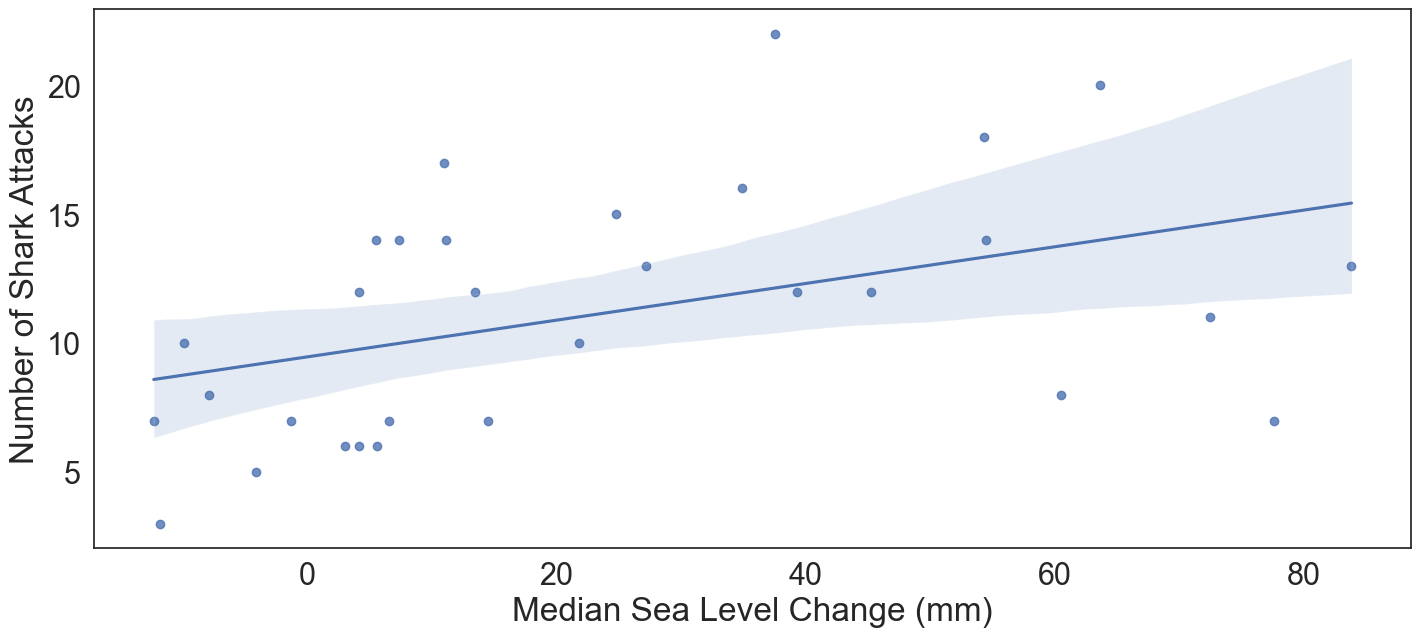

In [35]:
ax = sns.regplot(data=pacific_sharks_merged, x='median_sea_level', y='num_of_shark_attacks')
ax.set(xlabel='Median Sea Level Change (mm)', ylabel='Number of Shark Attacks')

##### Analysis of These Results

The positive slope/coefficient given by the regression model is 0.0711 which informs us that there is an increasing linear relationship between sea level change and number of unprovoked shark attacks. Although the coefficient is at first glance very small and close to 0, giving us a first impression that there actually might not be a significant correlation between the two variables, this completely makes sense if you recall that the largest difference in shark attacks between two different years was only 21.

The p-value given was 0.016 and it's low value (< 0.05) suggests that the slope between our two variables is not zero. In other words, it suggests that changes in median sea level does, in fact, change the number of shark attacks per year.

Finally, our confidence interval of [0.014, 0.128] (shown visually by the blue shaded area on the regression plot) suggests that other potential coefficients/slopes fall into this range with 95% confidence. While we notice that this confidence interval does not include the slope of 0 in its range (meaning, yet again, that we are confident that there is a relationship between sea level and shark attacks), we also take note when looking at the regression plot that the range varies significantly. This is most likely due to the points on the graph that are very far from the line of regression (especially towards more recent years) which indicate that the relationship between our two variables are not very accurate to that line, despite the line being the 'line of best fit'. This also means that if we were to predict the number of shark attacks on a future year, the range of possible values can be relatively large.

Now let's go ahead and do the same procedure above, but with **atlantic** sea level measurements and **east coast** shark attacks.

In [36]:
# create dataframe for # of shark attacks per year
num_shark_atks_per_year = sharks_df[sharks_df['West/East Coast'] == 'East Coast']
num_shark_atks_per_year = num_shark_atks_per_year.groupby(['Year'])['Year'].size().reset_index(name='num_of_shark_attacks')

num_shark_atks_per_year

,Year,num_of_shark_attacks
0,1881,3
1,1882,1
2,1883,3
3,1884,1
4,1886,1
...,...,...
120,2018,23
121,2019,31
122,2020,29
123,2021,35


Let's create a lineplot to visualize the number of shark attacks in the east coast over the years.

[Text(0.5, 1.0, 'Shark Attacks Per Year (East Coast)')]

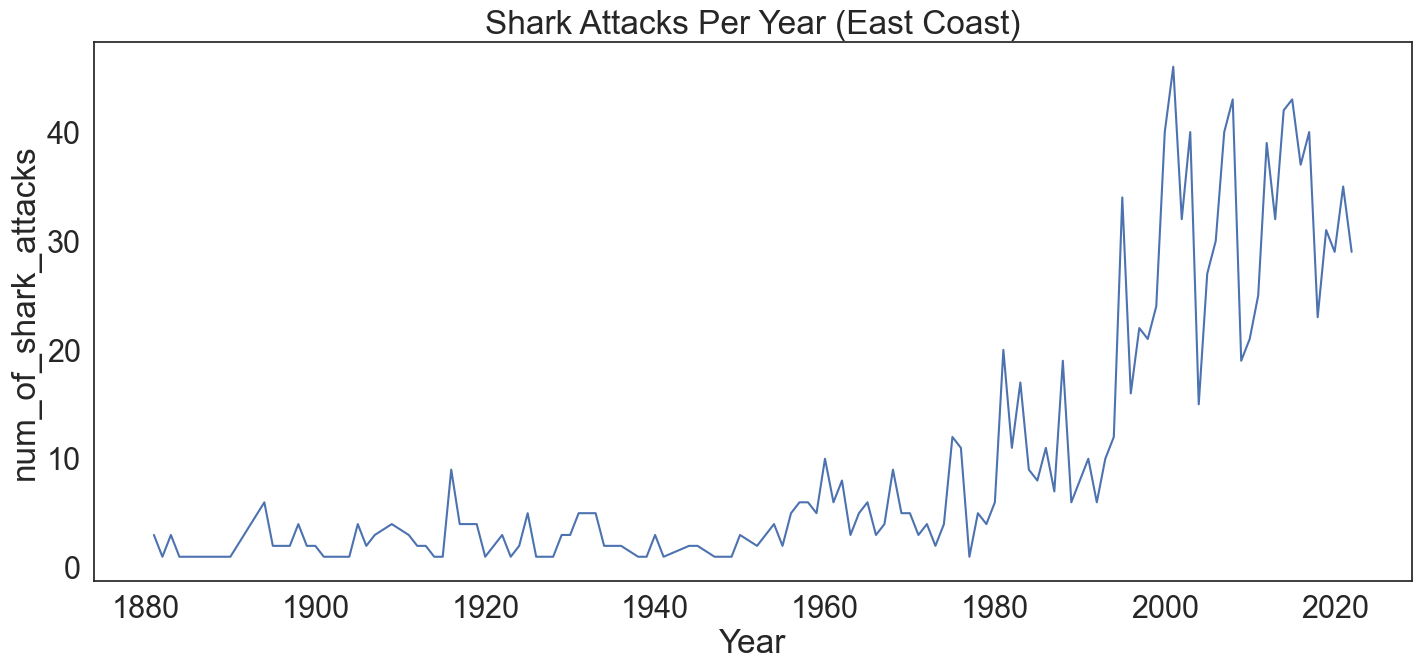

In [37]:
sns.lineplot(data=num_shark_atks_per_year, x='Year', y='num_of_shark_attacks').set(title='Shark Attacks Per Year (East Coast)')

Taking a look at this lineplot, we notice that the trend is very similar to the west coast shark attack data, but we also see a slight difference in the max number of shark attacks on a given year which for the east coast seems to be about 45, where for the west coast it was about 22. 

Let's go ahead and look at the sea level measurements of the atlantic ocean.

##### Obtain median sea level measurement for the atlantic ocean by year

In [38]:
sl_atlantic_new = sl_atlantic_df.apply(create_single_level_measurement, axis=1)
sl_atlantic_new['year'] = sl_atlantic_new['year'].astype(int)
sl_atlantic_new = sl_atlantic_new.drop(['TOPEX/Poseidon', 'Jason-1', 'Jason-2', 'Jason-3'], axis=1)

# calculate median for each year in the dataframe
sl_atlantic_new = sl_atlantic_new.groupby(['year'])['Sea Level'].median().reset_index(name='median_sea_level')

We now merge the dataset of yearly median sea level and number of shark attacks to be used to perform linear regression.

In [39]:
# merge both dataframes
atlantic_sharks_merged = pd.merge(sl_atlantic_new, num_shark_atks_per_year, how='inner', left_on='year', right_on='Year')
atlantic_sharks_merged = atlantic_sharks_merged.drop(['Year'], axis=1)
atlantic_sharks_merged

,year,median_sea_level,num_of_shark_attacks
0,1992,-13.930,6
1,1993,-17.020,10
2,1994,-15.375,12
3,1995,-3.280,34
4,1996,-7.925,16
5,1997,-8.110,22
6,1998,1.160,21
7,1999,15.130,24
8,2000,15.060,40
9,2001,-1.620,46


Run linear regression between sea level change and number of shark attacks

In [40]:
# run OLS
outcome, predictors = patsy.dmatrices('num_of_shark_attacks ~ median_sea_level', atlantic_sharks_merged)
mod = sm.OLS(outcome, predictors)
result = mod.fit()

Output our results

In [41]:
print(result.summary())

                             OLS Regression Results                             
Dep. Variable:     num_of_shark_attacks   R-squared:                       0.167
Model:                              OLS   Adj. R-squared:                  0.138
Method:                   Least Squares   F-statistic:                     5.806
Date:                  Mon, 21 Nov 2022   Prob (F-statistic):             0.0225
Time:                          16:01:06   Log-Likelihood:                -114.35
No. Observations:                    31   AIC:                             232.7
Df Residuals:                        29   BIC:                             235.6
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           

##### Our Results

Notice in our results summary that
* The slope/coefficient is **0.1619**
* The p-value = **0.023**
* The 95% Confidence Interval ranges from **[0.024, 0.299]**

Showing this in a regression plot:

[Text(0.5, 0, 'Median Sea Level Change (mm)'),
 Text(0, 0.5, 'Number of Shark Attacks')]

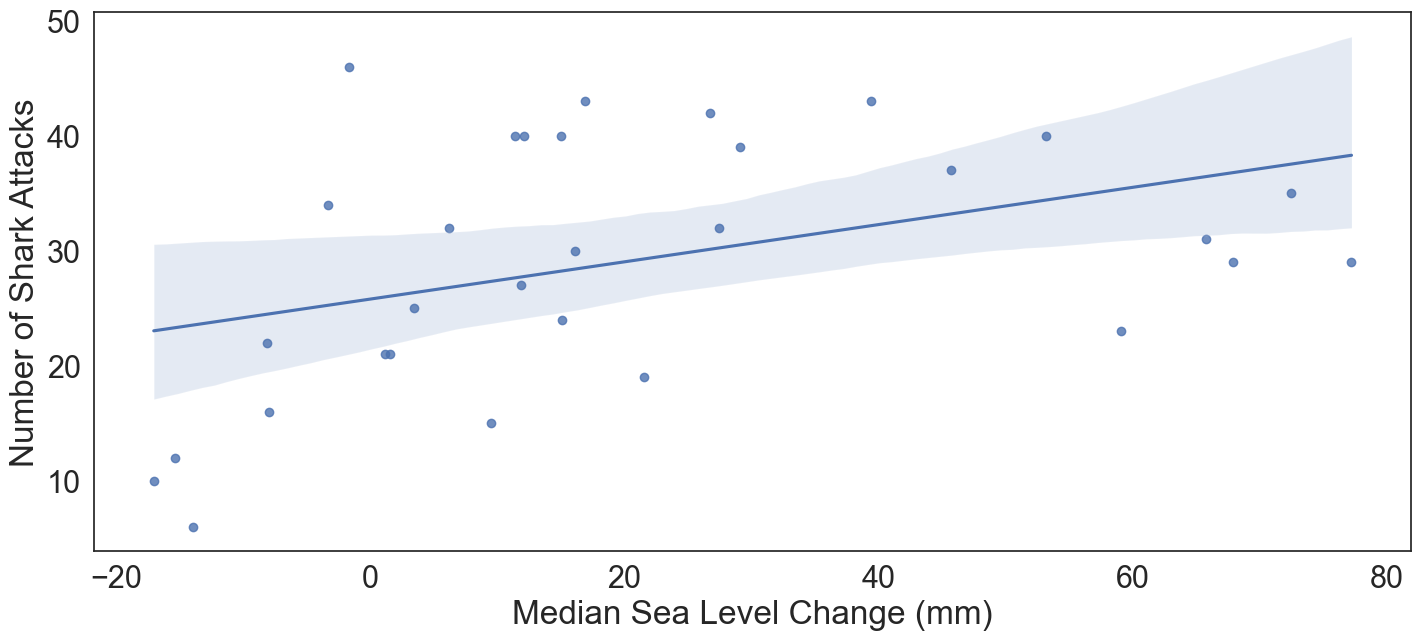

In [42]:
# plot data and linear regression model fit
ax = sns.regplot(data=atlantic_sharks_merged, x='median_sea_level', y='num_of_shark_attacks')
ax.set(xlabel='Median Sea Level Change (mm)', ylabel='Number of Shark Attacks')

##### Analysis of Results

The positive slope/coefficient given by the regression model is 0.1619 which informs us that there is also an increasing linear relationship between atlantic sea level change and number of unprovoked shark attacks in the east coast. Compared to our west coast analysis (coefficient = 0.0711), this is a significantly slope, and it makes sense given that there were most shark attacks recorded in recent years compared its west coast counterpart like we mentioned earlier. 

The p-value given was 0.023 and it's low value (< 0.05) suggests that the slope between our two variables is also not zero. Again, in other words, it suggests that changes in atlantic sea level does seem change the number of shark attacks in the east coast per year.

Finally, our confidence interval of [0.024, 0.299] (shown visually by the blue shaded area on the regression plot) suggests that other potential coefficients/slopes fall into this range with 95% confidence. While we notice that this confidence interval does not include the slope of 0 in its range (meaning, yet again, that we are confident that there is a relationship between atlantic sea level and east coast shark attacks), we also take note when looking at the regression plot that the range varies significantly, similar to our west coast analysis. This is, again, most likely due to the points on the graph that are very far from the line of regression which indicate that the relationship between our two variables are not very accurate to that line, despite the line being the 'line of best fit'. This also means that if we were to predict the number of shark attacks on a future year, the range of possible values can be relatively large.

## Exploring Correlation Between Ocean Temperature Anomalies and Shark Attacks

<AxesSubplot: xlabel='Year', ylabel='Count'>

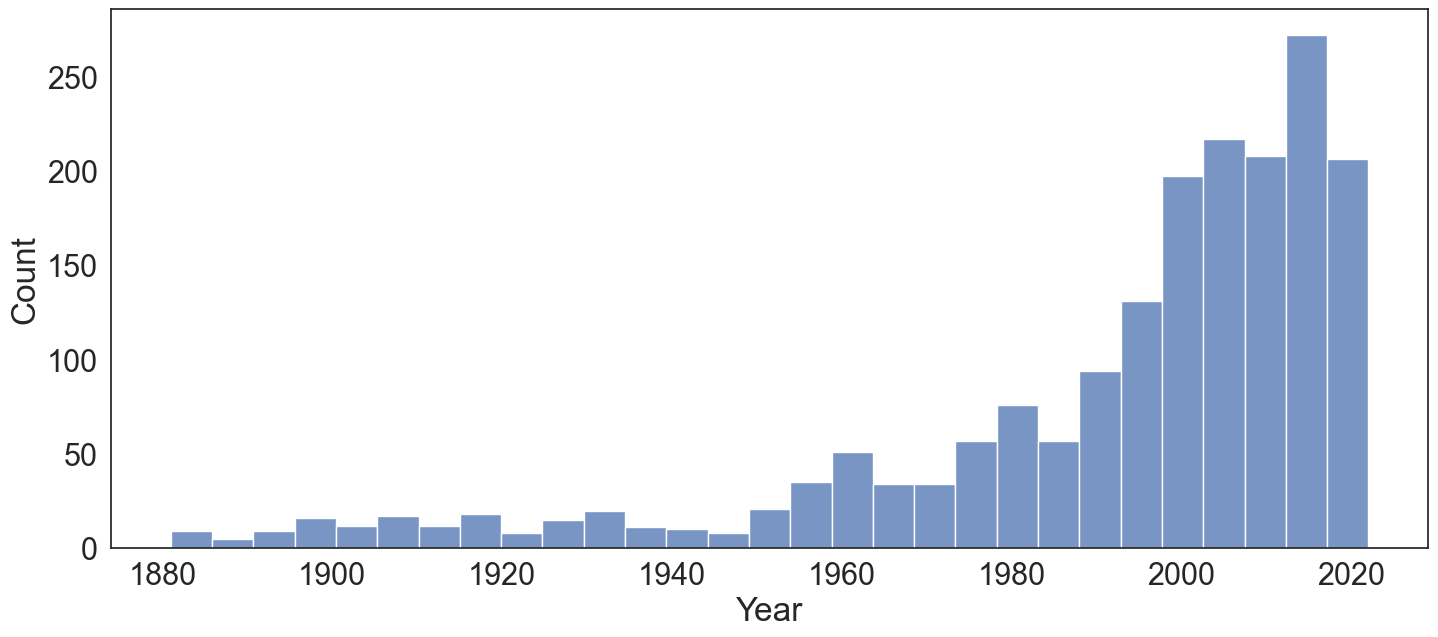

In [37]:
#shark attacks over the years
sns.histplot(data = sharks_df['Year'])

As the years go by staring from 1880 to 2021 it seems that in the U.S. shark attakcs increase. This could be due to increase in reports or other factors.

Lets explore the data set more and see if activites play a role in why people are getting attacked by sharks.

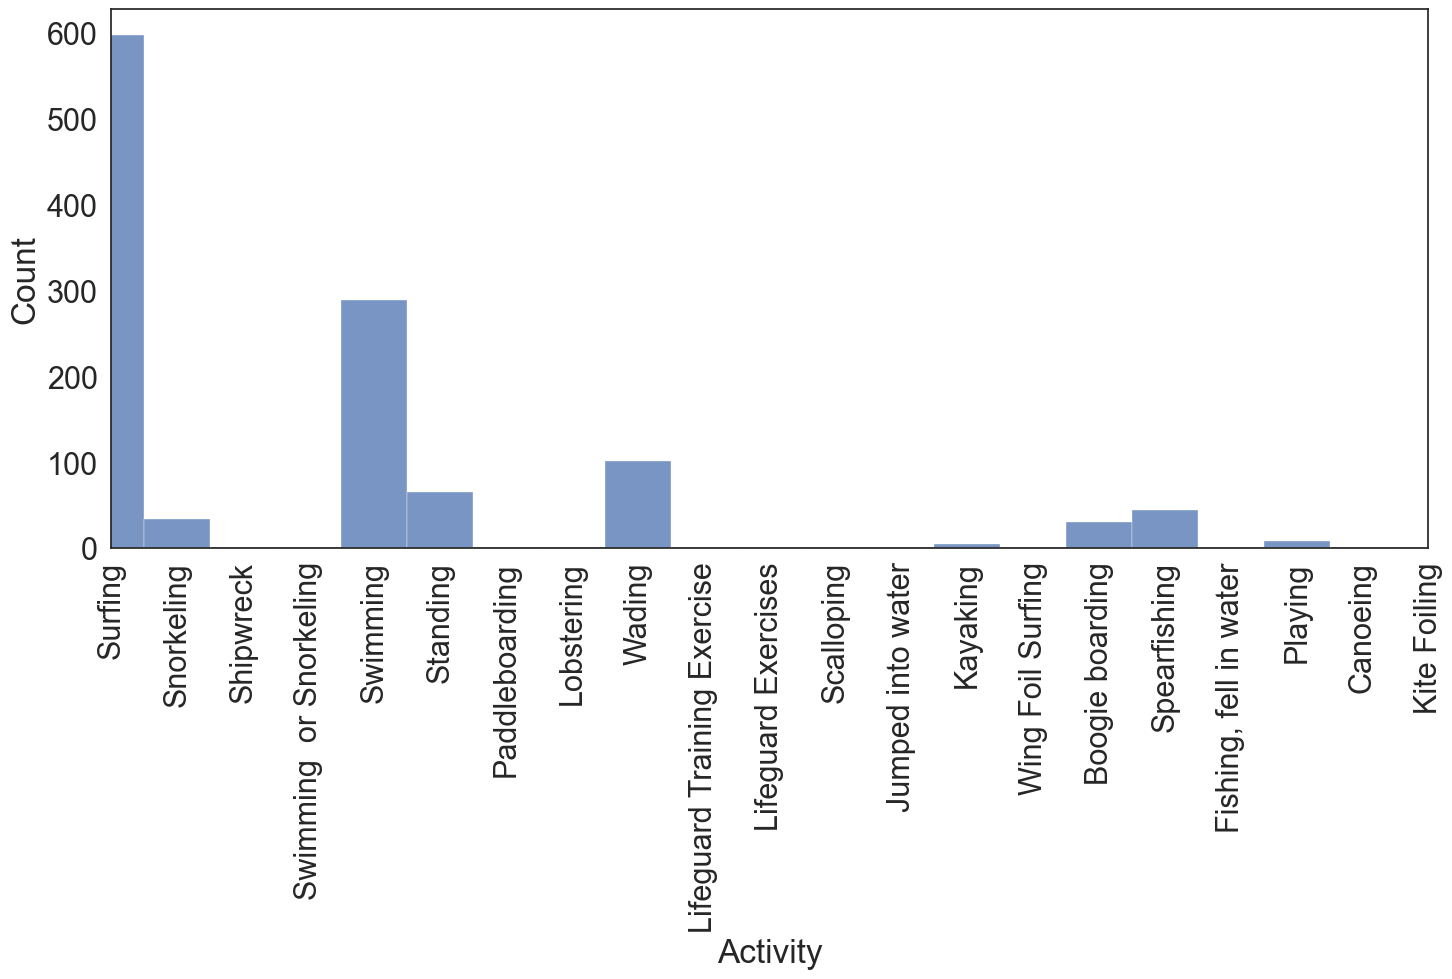

In [38]:
# activites being done  while being attacked
sns.histplot(data = sharks_df, x = 'Activity')
plt.xticks( rotation = 90)
plt.xlim(0, 20)
f1 = plt.gcf()

It was seen that surfing is the activity with the highest amount of shark attacks. Lets explore the data further.

<AxesSubplot: xlabel='West/East Coast', ylabel='count'>

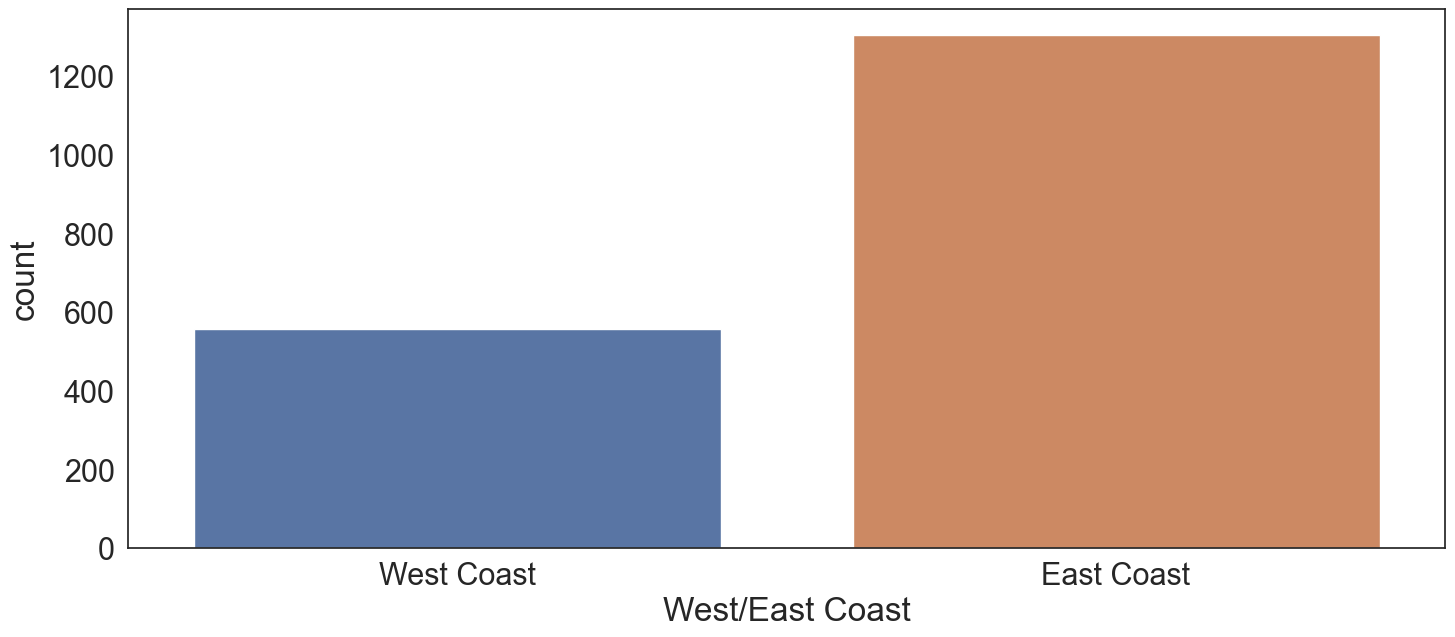

In [39]:
# shark attacks on the east coast vs the west coast
sns.countplot(data = sharks_df, x= sharks_df['West/East Coast'])

Exploring the Data Further the East Coast of the U.S. seems to have much more recorded Shark attacks.

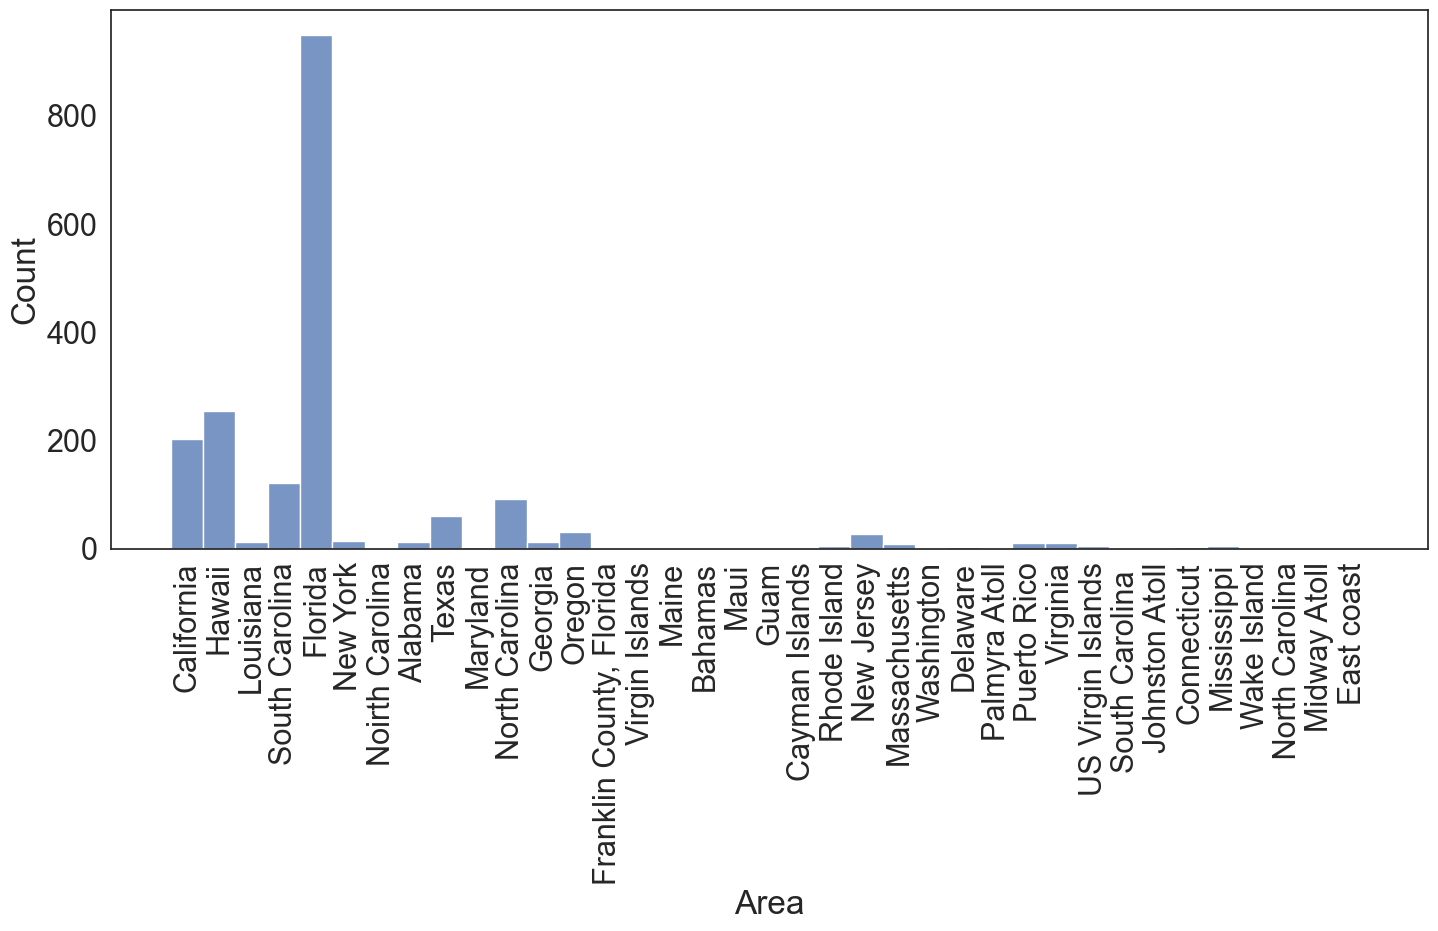

In [40]:
sns.histplot(data = sharks_df, x= 'Area')
plt.xticks(rotation= 90)
f1 = plt.gcf()

Looking at the data broken down by states it seems that Florida is is the main cotributer to the outcome of the the East Coast having more shark attacks.

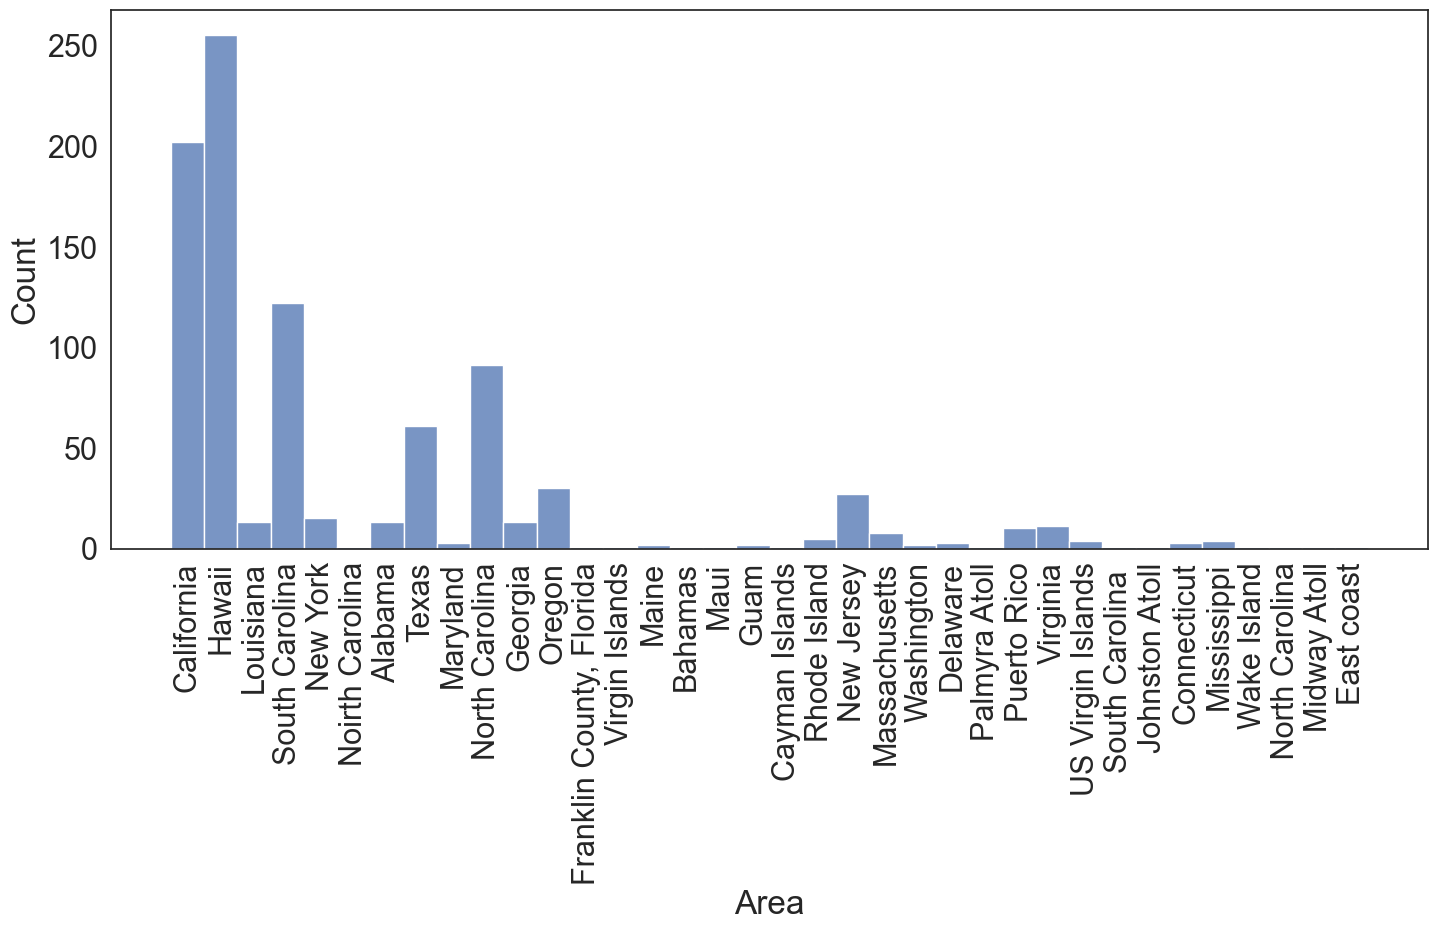

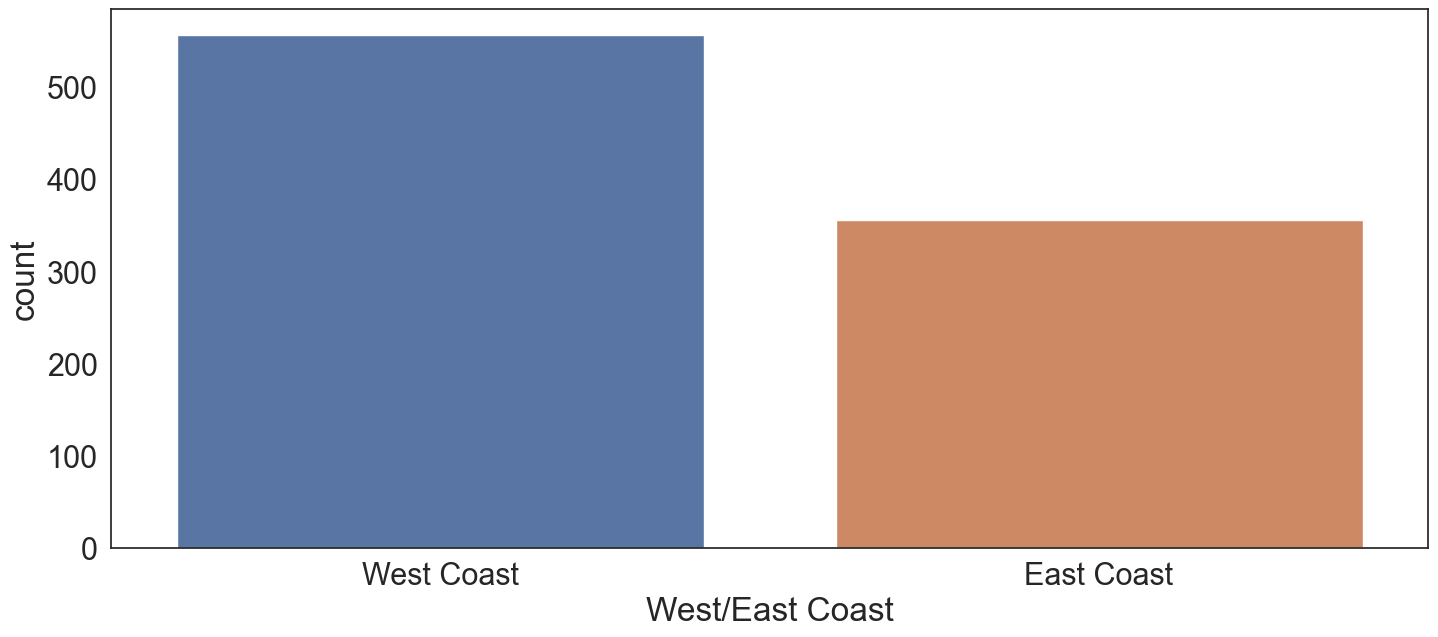

In [41]:
# Shark attacks on the East Coast vs. the West Coast and shark attacks per area excluding Florida
noFlorida = sharks_df[sharks_df.Area != 'Florida']
sns.histplot(data = noFlorida, x= 'Area')
plt.xticks(rotation= 90)
plt.show()
sns.countplot(data = noFlorida, x= noFlorida['West/East Coast'])
plt.show()

With the absence of Florida we see that the West Coast now out ranks the East Coast in terms of number of shark attacks. Now we see that Hawaii is leading in state with most shark attacks.

                                Change in tempurature per year  \
Change in tempurature per year                        1.000000   
Shark attack per year                                 0.825786   

                                Shark attack per year  
Change in tempurature per year               0.825786  
Shark attack per year                        1.000000  


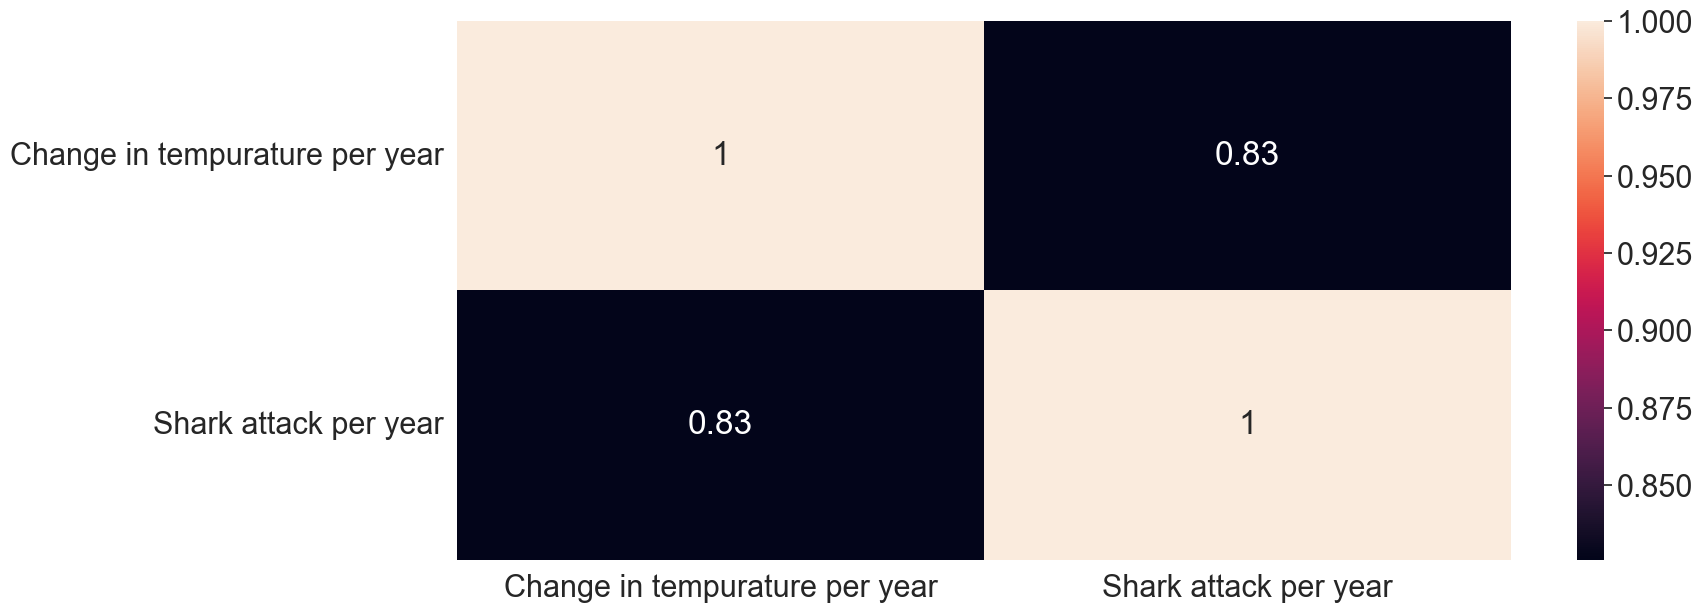

In [48]:
#setting up a list of all the relavent years (1881 - 2022)
relevantTimeFrame = []
for i in range(1881,2023):
    relevantTimeFrame.append(i)
#creating df to store shark attacks per year
y = pd.DataFrame(index = relevantTimeFrame)
#organizing the shark attack data and puttign it into the relevantTimeFrame df
y['Shark attack per year'] = sharks_df['Year'].value_counts()
y = y.iloc[:-1]
temp = temp_df.iloc[1:]
y['Shark attack per year'] = y['Shark attack per year'].fillna(0)
#setting up DF that be tested for correlation
correlationDF = temp.set_index('year')
# wrangling data into same DF
extractedSharkData= y['Shark attack per year']
correlationDF = correlationDF.join(extractedSharkData)
#renaming the columns using df.rename(columns = {'old_col1':'new_col1', 'old_col2':'new_col2'}, inplace = True)
correlationDF = correlationDF.rename(columns = {'temperature_anomaly_cel':'Change in tempurature per year'})
#running test and plotting results
Shark_Correlation = correlationDF.corr()
print(Shark_Correlation)
sns.heatmap(Shark_Correlation, annot=True)
plt.show()

Looking at the correlation coefficient of 0.83 between shark attacks and sea tempreature change over the years due to climate change this denotes a strong correlation as the coefficient is above 0.7 based on The Basic Practice of Statistics (6th ed.) by Diana Mindrila, Ph.D.
Phoebe Balentyne, M.Ed..